In [1]:
from cytoreactors.inference.BPI import Particles, basic_do_jump, basic_next_jump, basic_jump_params
import numpy as np
import cytoreactors.modeling.EL222_model_2V_3P_A as model
from cytoreactors.modeling.simulation import simulate_analytic, light_profile_to_traj
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cProfile
from time import time

In [2]:
# decide light profile (btween parameter change)
light_profile_basic = sum([[(40,0.5),(0,1.5)] for i in range(3)],[])
# decide parameter changes
#param_changes = [('sigma',2000),('sigma',1500),('sigma',1000)]
#param_changes = [('deg_m',1.58),('deg_m',1.1),('deg_m',0.55)]
param_changes = [('deg_fp',0.41),('deg_fp',0.41),('deg_fp',0.41)]
# make complete light_profile
light_profile = sum([light_profile_basic for i in range(len(param_changes)+1)], [])
duration = sum([d for _,d in light_profile])

In [3]:
# decide fp measurements
t_measurements = np.arange(0,duration,1.2)
t_measurements

array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
       13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8])

In [4]:
# ground truth / data
def simulate_truth(param_changes,light_profile_basic):
    pars = model.default_model_pars.copy()
    y0 = [0,0]
    t0 = 0
    ts = []
    ys = []
    pars_traj = {p:[] for p in pars}
    for par_name,par_value in param_changes:
        t,y,_ = simulate_analytic(model, pars, light_profile_basic, y0, t0=t0,  n_evals=30)
        ys.append(y)
        ts.append(t)
        y0 = y.transpose()[-1]
        t0 = t[-1]
        for p in pars:
            pars_traj[p].append(pars[p]*np.ones(len(t)))
        pars[par_name] = par_value
    t,y, _ = simulate_analytic(model, pars, light_profile_basic, y0, t0=t0, n_evals=30)    
    ys.append(y)
    ts.append(t)
    for p in pars:
        pars_traj[p].append(pars[p]*np.ones(len(t)))
    ts = np.concatenate(ts)
    ys = np.hstack(ys)
    pars_traj = {p:np.concatenate(par_traj) for p,par_traj in pars_traj.items()}
    return ts,ys[-1],pars_traj

In [5]:
t_real,fp_real,pars_traj_real = simulate_truth(param_changes, light_profile_basic)

In [6]:
# integrate measurements into light profile
light_profile_and_measurements = [(I,d,False) for I,d in light_profile]
for t_measurement in t_measurements:
    i = 0
    t = 0
    while t + light_profile_and_measurements[i][1] < t_measurement:
        t += light_profile_and_measurements[i][1]
        i += 1
    lpm_before = light_profile_and_measurements[:i] + [(light_profile_and_measurements[i][0],t_measurement-t,True)]
    lpm_after = []
    if light_profile_and_measurements[i][1]-t_measurement+t>0:
        lpm_after = [(light_profile_and_measurements[i][0],light_profile_and_measurements[i][1]-t_measurement+t,False)]
    lpm_after += light_profile_and_measurements[i+1:]
    light_profile_and_measurements = lpm_before + lpm_after

In [7]:
def sample_unif_log(vmin,vmax):
    return vmin*np.exp(np.random.rand()*(np.log(vmax)-np.log(vmin)))

def do_jump(pars, jump_pars, changing_pars):
    i_par_changing = np.random.randint(len(changing_pars))
    pars[changing_pars[i_par_changing]] = sample_unif_log(jump_pars['vmin'][changing_pars[i_par_changing]], 
                                                          jump_pars['vmax'][changing_pars[i_par_changing]])
    
jump_params = {'jump_rate':0.2, 'vmin':{'sigma':500, 'deg_m':1.25, 'deg_fp':0.1}, 
             'vmax':{'sigma':2500, 'deg_m':2.5, 'deg_fp':0.6}}

In [8]:
def do_bpi_learning(particles, light_profile_and_measurements, fp_real, t_real, sigma_fp_measurement):
    tcomp_0 = time()
    t = 0
    n_tps = len(light_profile_and_measurements)
    pars_traj = {p_name:np.empty((particles.n_particles, n_tps+1)) for p_name in particles.param_names}
    t_tps = np.zeros(n_tps+1)
    i_tp = 0
    t_meas = []
    fp_meas = []
    for p_name in pars_traj:
        pars_traj[p_name][:,0] = particles.params[p_name]
    for (I,d,measuring) in light_profile_and_measurements:
        particles.advance([(I,d)], basic_next_jump, do_jump, jump_params, particles.param_names)
        t += d
        if measuring:
            fp = fp_real[np.argmax(t_real >= t)]
            fp_noisy = fp + np.random.normal(scale=sigma_fp_measurement)
            particles.treat_new_measurement(fp_noisy, sigma_fp_measurement)
            t_meas.append(t)
            fp_meas.append(fp_noisy)
        for p_name in pars_traj:
            pars_traj[p_name][:,i_tp+1] = particles.params[p_name]
        t_tps[i_tp+1] = t
        i_tp += 1
    tcomp_end = time()
    print(f'{tcomp_end-tcomp_0:.2f} seconds')
    return t_tps,pars_traj,t_meas,fp_meas

In [9]:
particles = Particles(n_particles=5000, model=model, init_param_uncertainty_delta_log=0.)
for ip in range(particles.n_particles):
    for p in particles.params:
        particles.params[p][ip] = sample_unif_log(jump_params['vmin'][p], 
                                                          jump_params['vmax'][p])


In [10]:
%load_ext snakeviz

In [11]:
%snakeviz t_tps,pars_traj,t_meas,fp_meas = do_bpi_learning(particles, light_profile_and_measurements, fp_real, t_real, 10)

22.27 seconds
 
*** Profile stats marshalled to file 'C:\\Users\\inbio\\AppData\\Local\\Temp\\tmpou_tcpe4'. 
Embedding SnakeViz in this document...


In [12]:
def plot_run(light_profile_and_measurements,fp_real,t_real,pars_traj_real,t_tps,pars_traj,t_meas,fp_meas):
    f,axs = plt.subplots(ncols=2, nrows=2, figsize=(13,7))
    axs = axs.ravel()
    #
    ax = axs[0]
    t,l = light_profile_to_traj([(I,d) for I,d,_ in light_profile_and_measurements])
    ax.plot(t,l*40,'b')
    ax.plot(t_meas,fp_meas,'go',markersize=5)
    ax.plot(t_real, fp_real,'r')
    ax.set_ylabel('Fluorescence')
    iparam = 1
    for p in pars_traj:
        ax = axs[iparam]
        ax.plot(t_tps, np.mean(pars_traj[p], axis=0),'k')
        ax.plot(t_tps, np.median(pars_traj[p], axis=0),'--k')
        ax.plot(t_tps, np.mean(pars_traj[p], axis=0) + np.std(pars_traj[p], axis=0),'b', linewidth=1)
        ax.plot(t_tps, np.mean(pars_traj[p], axis=0) - np.std(pars_traj[p], axis=0),'b', linewidth=1)
        ax.plot(t_real, pars_traj_real[p], 'r')
        iparam += 1
        ax.set_title(p)        
        ax.set_ylim([0,1.5*pars_traj[p].mean()])
        ax.grid()
        ax.legend(['mean of particles','median','mean + sd','mean - sd', 'real value'])
    f.tight_layout()

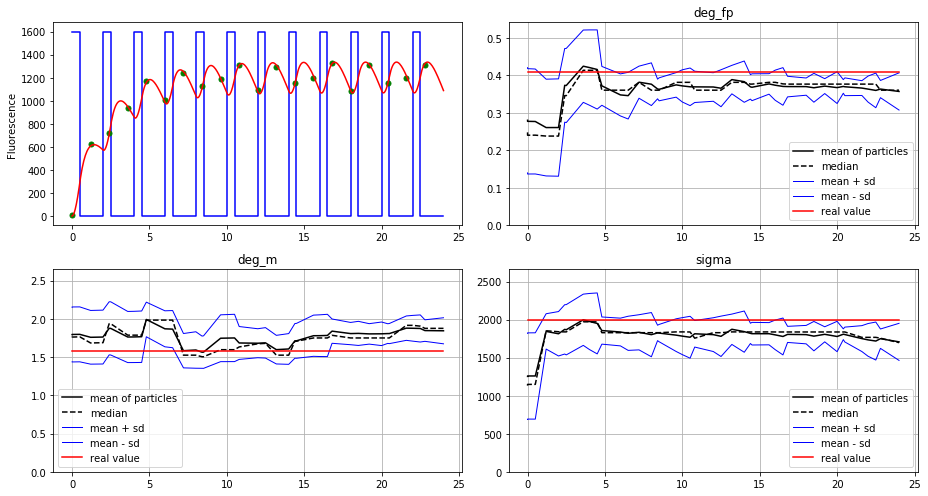

In [13]:
plot_run(light_profile_and_measurements, fp_real, t_real, pars_traj_real, t_tps, pars_traj, t_meas, fp_meas)